# In this script, we will look into the SSQ trend whithin dropouts and completed ones seperately.

SSQ experimental increase as percentage of practice SSQ as a function of time and function of condition

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [17]:
# Initialization
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta, datetime

import matplotlib.pyplot as plt
import matplotlib.table as tbl
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20})


import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import ProbPlot

## 1. Rading the demographics

To read the participants IDs and groups.
- IDs: we will look into completed and ss_incompleted seperately. 
- Groups:

In [18]:
# setting the path to the qualitative data master list
Qualitative_Path = ("N:\Shabnam Haghzare\\01- AV_OA_Study\\Master_Data_List\\Qualitative\\")

# reading the demographic data into a dataframe--- index = participant ID, colums = feature label
Demographics = pd.read_excel(Qualitative_Path + "Demographics.xlsx", sheet_name = "Master Data")
Demographics = Demographics.set_index('Participant ID')

status = Demographics.groupby('Participant Status')

completed_IDs = np.array(status.groups['All Completed'])
ss_incompleted_IDs = np.array(status.groups['Exp Incomplete'])
excluded_IDs = np.array(status.groups['Did not Come In'])
practiceDone_IDs = np.array(status.groups['Practice Completed']) #only relevant in the third (Two session) design 

In [19]:
completed_IDs

array([4., 7., 9.])

In [20]:
ss_incompleted_IDs

array([ 2.,  5.,  6., 10., 11., 12., 14., 15., 16., 18., 24.])

In [21]:
## Now we will read the groups

In [22]:
completed_groups = Demographics[['Manual/Auto Order', 'Participant Condition Order', 'Participant Completion Order','Participant Group Order']].loc[completed_IDs]
incomplete_groups = Demographics[['Manual/Auto Order', 'Participant Condition Order', 'Participant Completion Order','Participant Group Order']].loc[ss_incompleted_IDs]

incomplete_groups

,Manual/Auto Order,Participant Condition Order,Participant Completion Order,Participant Group Order
Participant ID,,,,
2.0,MA,RTB (4),"PM,PA,RM,RA,TM,TA","PM,PA,RM,RA,TM,TA,BM,BA"
5.0,AM,RTB (4),"PM,PA,RA,RM","PM,PA,RA,RM,TA,TM,BA,BM"
6.0,AM,RTB (4),"PM,PA,RA,RM","PM,PA,RA,RM,TA,TM,BA,BM"
10.0,MA,BTR (2),"PM,PA,BM,BA","PM,PA,BM,BA,TM,TA,RM,RA"
11.0,MA,RBT (3),"PM,PA,RM,RA","PM,PA,RM,RA,BM,BA,TM,TA"
12.0,NaN,BRT (1),"PM,PA","PM,PA,NM,NA,TM,TA,RM,RA"
14.0,MA,BTR (2),"PM,PA,BM,BA,TM","PM,PA,BM,BA,TM,TA,RM,RA"
15.0,AM,BRT (1),"PM,PA,BA,BM,RA","PM,PA,BA,BM,RA,RM,TA,TM"
16.0,MA,BRT (1),"PM,PA,BM,BA,RM,RA","PM,PA,BM,BA,RM,RA,TM,TA"


## 2. SSQ Reading 

Will get four sets os scores for each of the completed and incomplete participnats.
Score Key: Nausea, Oculumotor Disturbance, Disorientation, Total Score

In [23]:
# reading the SSQ data into a dataframe--- index = participant ID, colums = feature label
SSQ = pd.read_excel(Qualitative_Path + "SSQ.xlsx", sheet_name = "Master_SSQ")
SSQ.columns = SSQ.loc[0,:]
SSQ.drop(index = 0)
SSQ = SSQ.set_index('Participant ID')
SSQ.drop(index = 'Participant ID', inplace=True)

    
def get_SSQ_subscores_for_given_participants(SSQ, IDs):
    SSQ = SSQ.loc[IDs].drop(columns = ['Status'])
    SSQ.astype(float)  
    SSQ_N = SSQ.iloc[:,0:8].astype(float)
    SSQ_OD = SSQ.iloc[:,8:16].astype(float)
    SSQ_D = SSQ.iloc[:,16:24].astype(float)
    SSQ_T = SSQ.iloc[:,24:32].astype(float)

    return SSQ_N,SSQ_OD,SSQ_D,SSQ_T

SSQ_N_C,SSQ_OD_C,SSQ_D_C,SSQ_T_C = get_SSQ_subscores_for_given_participants(SSQ, completed_IDs)

In [24]:
SSQ_N_C

,PM,PA,BM,BA,TM,TA,RM,RA
Participant ID,,,,,,,,
4,9.54,0.00,28.62,28.62,38.16,28.62,38.16,47.70
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.54
9,28.62,19.08,38.16,28.62,57.24,28.62,57.24,19.08


## 3. Increase with Time

### 3.1 Completed Participants
We will have sorted SSQ by the order in which they were administered. i.e. the order of the trials. 

In [25]:
def sort_to_trial_order(SSQ_scores, groups):
    SSQ_ordered = pd.DataFrame(columns = ["Practice Manual", "Practice Auto", "Exp-1", "Exp-2", "Exp3",
                                          "Exp-4", "Exp-5", "Exp-5"], dtype=float)
    
    SSQ_group = pd.concat([SSQ_scores, groups],1)
    for ID,row in SSQ_group.iterrows():
        SSQ_ordered.loc[ID,:] = SSQ_group.loc[ID,SSQ_group.loc[ID, 'Participant Group Order'].split(",")].values
    
    return SSQ_ordered

In [26]:
# getting the ordered scores for each of the subscores for completed participants

SSQ_N_C_ordered = sort_to_trial_order(SSQ_N_C, completed_groups)
SSQ_N_C_ordered['SSQ_Scale'] = "Nausea Score"

SSQ_OD_C_ordered = sort_to_trial_order(SSQ_OD_C, completed_groups)
SSQ_OD_C_ordered['SSQ_Scale'] = "Oculomotor Disturbance Score"

SSQ_D_C_ordered = sort_to_trial_order(SSQ_D_C, completed_groups)
SSQ_D_C_ordered['SSQ_Scale'] = "Disorientation Score"

SSQ_T_C_ordered = sort_to_trial_order(SSQ_T_C, completed_groups)
SSQ_T_C_ordered['SSQ_Scale'] = "Total Score"

In [27]:
SSQ_complete = pd.concat([SSQ_N_C_ordered,SSQ_OD_C_ordered,SSQ_D_C_ordered, SSQ_T_C_ordered],0)

In [28]:
SSQ_complete

,Practice Manual,Practice Auto,Exp-1,Exp-2,Exp3,Exp-4,Exp-5,Exp-5,SSQ_Scale
4,9.54,0.00,38.16,47.70,38.16,28.62,28.62,28.62,Nausea Score
7,0.00,0.00,0.00,9.54,0.00,0.00,0.00,0.00,Nausea Score
9,28.62,19.08,19.08,57.24,28.62,57.24,38.16,38.16,Nausea Score
4,7.58,0.00,7.58,15.16,7.58,15.16,15.16,15.16,Oculomotor Disturbance Score
7,0.00,0.00,0.00,7.58,0.00,0.00,0.00,0.00,Oculomotor Disturbance Score
9,15.16,15.16,7.58,15.16,7.58,30.32,22.74,22.74,Oculomotor Disturbance Score
4,0.00,0.00,13.92,27.84,27.84,27.84,13.92,13.92,Disorientation Score
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Disorientation Score
9,13.92,13.92,13.92,13.92,13.92,27.84,27.84,27.84,Disorientation Score
4,7.44,0.00,22.32,33.48,26.04,26.04,22.32,22.32,Total Score


In [29]:
SSQ_complete.groupby(['SSQ_Scale']).mean()

,Practice Manual,Practice Auto,Exp-1,Exp-2,Exp3,Exp-4,Exp-5,Exp-5
SSQ_Scale,,,,,,,,
Disorientation Score,4.64,4.640000,9.280000,13.920000,13.920000,18.56,13.920000,13.920000
Nausea Score,12.72,6.360000,19.080000,38.160000,22.260000,28.62,22.260000,22.260000
Oculomotor Disturbance Score,7.58,5.053333,5.053333,12.633333,5.053333,15.16,12.633333,12.633333
Total Score,9.92,6.233333,12.400000,24.800000,14.880000,23.56,18.600000,18.600000


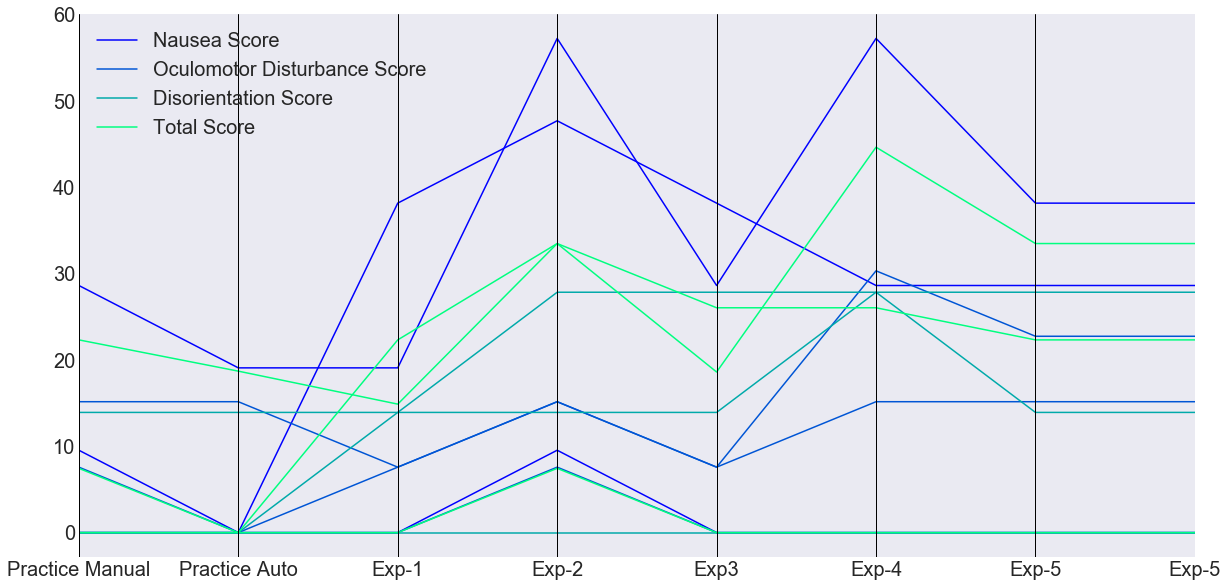

In [30]:
# multiple line plot
from pandas.plotting import parallel_coordinates
params = {'legend.fontsize': 10,
          'legend.handlelength': 0.2}

fig, ax = plt.subplots(figsize=(20,10))
parallel_coordinates(SSQ_complete, 'SSQ_Scale',colormap='winter')
plt.legend()

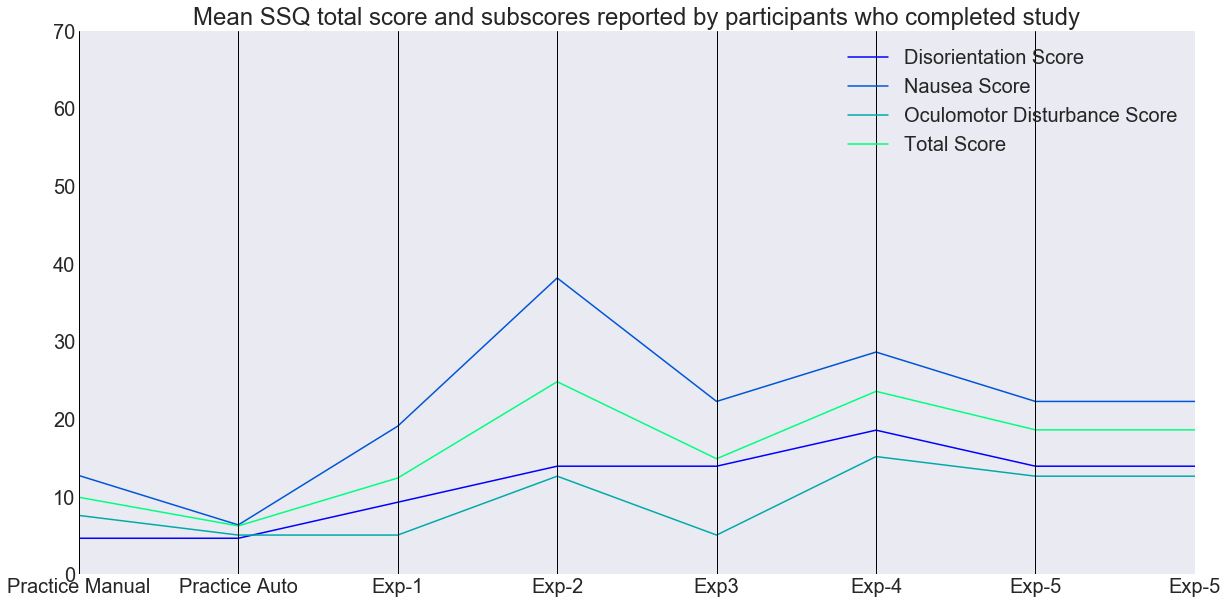

In [42]:
## Plotting the mean
data = SSQ_complete.groupby(['SSQ_Scale']).mean().reset_index(inplace= False)
fig, ax = plt.subplots(figsize=((20,10)))
parallel_coordinates(data, 'SSQ_Scale',colormap='winter').set(ylim = (0,70))
plt.title("Mean SSQ total score and subscores reported by participants who completed study")

plt.legend()

### 3.2 Incomplete Participants 

Same as above for the incomplete participants


In [43]:
def NA_for_not_available(df):
    for i in df.index:
        for j in df.keys():
            if (j in incomplete_groups['Participant Completion Order'][i]) == False:
                df.loc[i,j] = "NaN"
    return df

def get_SSQ_subscores_for_incomplete_participants(SSQ, IDs):
    SSQ = SSQ.loc[IDs].drop(columns = ['Status'])
    SSQ.astype(float)  
    SSQ_N = NA_for_not_available(SSQ.iloc[:,0:8].astype(float))
    SSQ_OD = NA_for_not_available(SSQ.iloc[:,8:16].astype(float))
    SSQ_D = NA_for_not_available(SSQ.iloc[:,16:24].astype(float))
    SSQ_T = NA_for_not_available(SSQ.iloc[:,24:32].astype(float))

    return SSQ_N,SSQ_OD,SSQ_D,SSQ_T

SSQ_N_IC,SSQ_OD_IC,SSQ_D_IC,SSQ_T_IC = get_SSQ_subscores_for_incomplete_participants(SSQ, ss_incompleted_IDs)


In [44]:
incomplete_groups['Participant Completion Order']

Participant ID
2.0        PM,PA,RM,RA,TM,TA
5.0              PM,PA,RA,RM
6.0             PM,PA,RA,RM 
10.0             PM,PA,BM,BA
11.0             PM,PA,RM,RA
12.0                   PM,PA
14.0         PM,PA,BM,BA,TM 
15.0         PM,PA,BA,BM,RA 
16.0      PM,PA,BM,BA,RM,RA 
18.0    PM,PA,BM,BA,RM,RA,TM
24.0             PM,PA,RM,RA
Name: Participant Completion Order, dtype: object

In [45]:
# getting the ordered scores for each of the subscores for completed participants

SSQ_N_IC_ordered = sort_to_trial_order(SSQ_N_IC, incomplete_groups)
SSQ_N_IC_ordered['SSQ_Scale'] = "Nausea Score"

SSQ_OD_IC_ordered = sort_to_trial_order(SSQ_OD_IC, incomplete_groups)
SSQ_OD_IC_ordered['SSQ_Scale'] = "Oculomotor Disturbance Score"

SSQ_D_IC_ordered = sort_to_trial_order(SSQ_D_IC, incomplete_groups)
SSQ_D_IC_ordered['SSQ_Scale'] = "Disorientation Score"

SSQ_T_IC_ordered = sort_to_trial_order(SSQ_T_IC, incomplete_groups)
SSQ_T_IC_ordered['SSQ_Scale'] = "Total Score"

SSQ_incomplete = pd.concat([SSQ_N_IC_ordered,SSQ_OD_IC_ordered,SSQ_D_IC_ordered, SSQ_T_IC_ordered],0)

In [46]:
SSQ_incomplete.replace('NaN', np.NaN, inplace = True)

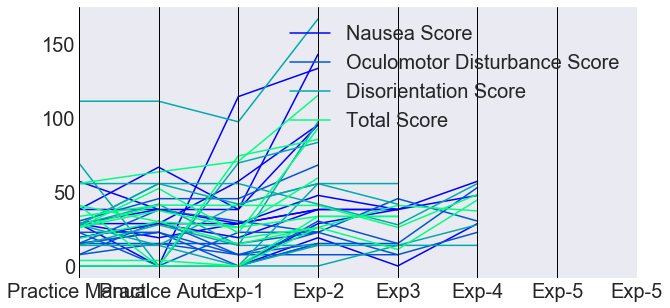

In [47]:
# multiple line plot for each incomplete participant
from pandas.plotting import parallel_coordinates

fig, ax = plt.subplots(figsize=(10,5))
parallel_coordinates(SSQ_incomplete, 'SSQ_Scale',colormap='winter')
plt.legend()

In [54]:
SSQ_incomplete

,Practice Manual,Practice Auto,Exp-1,Exp-2,Exp3,Exp-4,Exp-5,Exp-5,SSQ_Scale
2,19.08,28.62,28.62,38.16,38.16,47.70,NaN,NaN,Nausea Score
5,28.62,0.00,114.48,133.56,NaN,NaN,NaN,NaN,Nausea Score
6,19.08,28.62,19.08,38.16,NaN,NaN,NaN,NaN,Nausea Score
10,57.24,38.16,38.16,95.40,NaN,NaN,NaN,NaN,Nausea Score
11,38.16,66.78,38.16,143.10,NaN,NaN,NaN,NaN,Nausea Score
12,28.62,38.16,NaN,NaN,NaN,NaN,NaN,NaN,Nausea Score
14,38.16,38.16,28.62,38.16,38.16,NaN,NaN,NaN,Nausea Score
15,0.00,0.00,0.00,28.62,38.16,NaN,NaN,NaN,Nausea Score
16,0.00,0.00,0.00,19.08,0.00,28.62,NaN,NaN,Nausea Score
18,28.62,19.08,28.62,47.70,38.16,57.24,NaN,NaN,Nausea Score


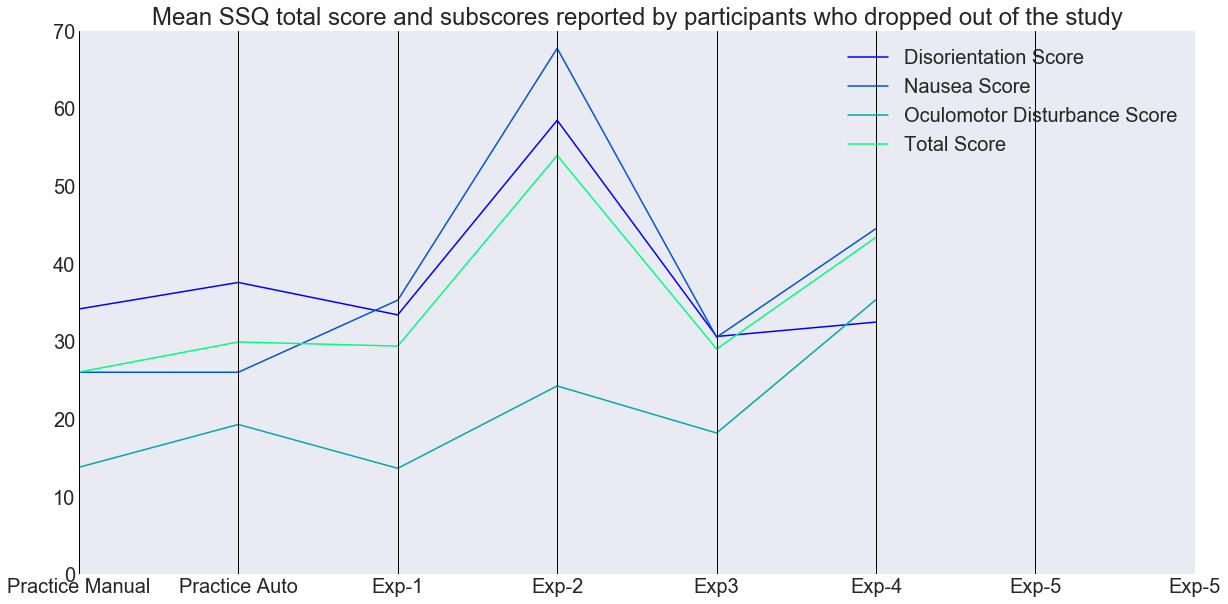

In [49]:
## Plotting the mean for all incomplete participants
data = SSQ_incomplete.groupby(['SSQ_Scale']).mean().reset_index(inplace= False)
fig, ax = plt.subplots(figsize=(20,10))
parallel_coordinates(data, 'SSQ_Scale',colormap='winter').set(ylim = (0,70))
plt.title("Mean SSQ total score and subscores reported by participants who dropped out of the study")
plt.legend()

## 4. SSQ Means among Complete and Incomplete;

#### 4.1 complete

[(0, 40)]

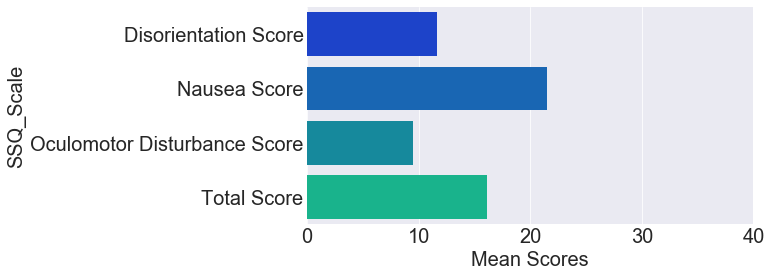

In [52]:
data = SSQ_complete.groupby(['SSQ_Scale']).mean().reset_index(inplace= False)
data["Mean Scores"] = data.mean(1)
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x ="Mean Scores", y='SSQ_Scale', data=data, palette='winter', orient = "h", capsize = 0.7).set(xlim = (0,40))

#### 4.2 Incomplete

[(0, 40)]

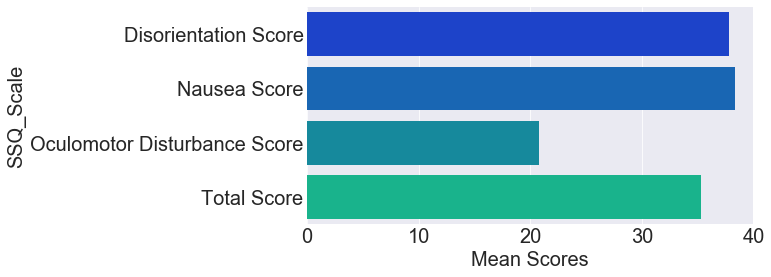

In [53]:
data = SSQ_incomplete.groupby(['SSQ_Scale']).mean().reset_index(inplace= False)
data["Mean Scores"] = data.mean(1)
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x ="Mean Scores", y='SSQ_Scale', data=data, palette='winter', orient = "h", capsize = 0.7).set(xlim = (0,40))
